In [1]:
from typing import Any, Self
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from icecream import ic
from lle import LLE, Action, World
from marlenv import Episode, Transition
from torch import device
import marlenv

import marl
from marl.other.subgoal import LocalGraph


class LocalGraphTrainer(marl.Trainer):
    def __init__(
        self,
        world: World,
        trajectory_length: int,
        t_o: int,
        t_p: float,
    ):
        super().__init__()
        all_pos = set((i, j) for i in range(world.height) for j in range(world.width)) - set(world.wall_pos)
        self.graph = LocalGraph(t_o, t_p, all_pos)
        self.world = world
        self.trajectory = [tuple[int, int](world.start_pos[0])]
        self.trajectory_length = trajectory_length

    def update_step(self, transition: Transition, time_step: int) -> dict[str, Any]:
        # print(time_step)
        prev_pos = self.trajectory[-1]
        agent_pos = self.world.agents_positions[0]
        diff = abs(agent_pos[0] - prev_pos[0] + agent_pos[1] - prev_pos[1])
        if diff > 1:
            action = Action(transition.action[0])
            ic(time_step, agent_pos, prev_pos, action)
        self.trajectory.append(agent_pos)
        if transition.is_terminal or (time_step > 0 and time_step % self.trajectory_length == 0):
            self.graph.add_trajectory(self.trajectory)
            self.trajectory = [agent_pos]
        if time_step > 0 and time_step % self.trajectory_length == 0:
            # pos = {x: (x[1], -x[0]) for x in self.graph.local_graph.nodes}
            # self.graph.show(pos)
            self.graph.partition()
            self.graph.clear()
        return {}

    def update_episode(self, episode: Episode, episode_num: int, time_step: int) -> dict[str, Any]:
        return {}

    def randomize(self):
        return

    def to(self, device: device) -> Self:
        return self

In [2]:
map_str = """
.  . . . .  . . . . .  @ . . . . . . . . . .
.  . . . .  . . . . .  @ . . . . . . . . . .
.  . . . .  . . . . .  @ . . . . . . . . . .
.  . . . .  . . . . .  @ . . . . . . . . . .
.  . . . .  . . . . .  @ . . . . . . . . . .
S0 . . . .  . . . . .  . . . . . . . . . . .
.  . . . .  . . . . .  @ . . . . . . . . . .
.  . . . .  . . . . .  @ . . . . . . . . . .
.  . . . .  . . . . .  @ . . . . . . . . . .
.  . . . .  . . . . .  @ . . . . . . . . . .
.  . . . .  . . . . .  @ . . . . . . . . . X
"""


In [14]:
from lle import World
import networkx as nx
from sklearn.cluster import SpectralClustering
from typing import Any, Literal
from marlenv import Episode, Transition
from torch._C import device


env = LLE.from_str(map_str).single_objective()
world = env.world

mask = np.ones((env.n_agents, env.n_actions), dtype=bool)
mask[:, Action.STAY.value] = False
env = marlenv.Builder(env).agent_id().available_actions_mask(mask).build()


class SpectralTrainer(marl.Trainer):
    def __init__(self):
        super().__init__("both", 1)
        self.edges = []
        # Spectral clustering with 2 clusters
        self.sc = SpectralClustering(2, affinity="precomputed", n_init=100)
        
    def update_step(self, transition: Transition, time_step: int) -> dict[str, Any]:
        logs = {}
        start_pos = transition.obs.data[0][:2]
        end_pos = transition.obs_.data[0][:2]
        self.edges.append((start_pos, end_pos))
        return logs

    def update_episode(self, episode: Episode, episode_num: int, time_step: int):
        logs = {}
        G = nx.Graph(self.edges)
        A = nx.adjacency_matrix(G).todense()  # Adjacency matrix of the graph

        labels = self.sc.fit_predict(A)
        # Visualize the clusters
        pos = {x: (x[1], -x[0]) for x in G.nodes}
        # pos = nx.spring_layout(G)
        nx.draw(G, pos, node_color=labels, with_labels=True)
        plt.show()
        return logs
    
    def randomize(self):
        return
    
    def to(self, device: device):
        return self


trainer = SpectralTrainer()
exp = marl.Experiment.create("logs/test", trainer=trainer, n_steps=50_000, test_interval=0, env=env)
exp.run(0)

heatmap = np.zeros((world.height, world.width))
for i in range(world.height):
    for j in range(world.width):
        pos = (i, j)
        n_hits = trainer.graph.hits.get(pos, 0)
        hit_percentage = n_hits / trainer.graph.node_apparition_count.get(pos, 1)
        heatmap[i, j] = hit_percentage
        ic(pos, n_hits, hit_percentage)
sns.heatmap(heatmap, annot=True, fmt=".2f")
plt.show()







Testing: 100%|██████████| 1/1 [00:00<00:00,  8.68Episode/s]


        0 Average score: 2.0


NetworkXError: Input is not a valid edge list

In [7]:
import random
lg = LocalGraph[int]()
trajectory = [random.randint(0, 10) for _ in range(50)] + [2] + [random.randint(11, 20) for _ in range(50)]

lg.add_trajectory(trajectory)
score, cut_set, node = lg.partition()

ic(score, cut_set, node)


ic| score: 0.020002000200020003
    cut_set: ([10, 9, 5, 4, 2, 7, 0, 6, 3, 8, 1], [16, 15, 19, 13, 14, 18, 12, 20, 17, 11])
    node: 16


(0.020002000200020003,
 ([10, 9, 5, 4, 2, 7, 0, 6, 3, 8, 1],
  [16, 15, 19, 13, 14, 18, 12, 20, 17, 11]),
 16)

{'affinity': 'precomputed', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 'auto', 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 2, 'n_components': None, 'n_init': 100, 'n_jobs': None, 'n_neighbors': 10, 'random_state': None, 'verbose': False}


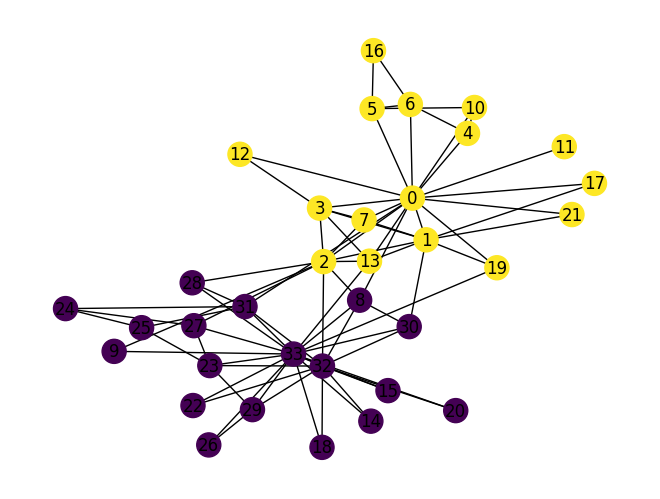

In [11]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Example graph
G = nx.karate_club_graph()  # Using the famous Karate Club graph as an example
A = nx.adjacency_matrix(G).todense()  # Adjacency matrix of the graph

# Spectral clustering with 2 clusters
sc = SpectralClustering(2, affinity="precomputed", n_init=100)
params = sc.get_params(deep=True)
print(params)
labels = sc.fit_predict(A)

# Visualize the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=labels, with_labels=True)
plt.show()
